# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from catboost import Pool, CatBoostClassifier, cv, sum_models

%matplotlib inline

# Read csv

In [2]:
df_train = pd.read_csv('/data/train.csv')
df_test = pd.read_csv('/data/test.csv')
df_sample_s = pd.read_csv('/data/sample_submission.csv')

In [3]:
df_train.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0


In [4]:
df_test.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75


# EDA

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [6]:
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>, <Axes: >]], dtype=object)

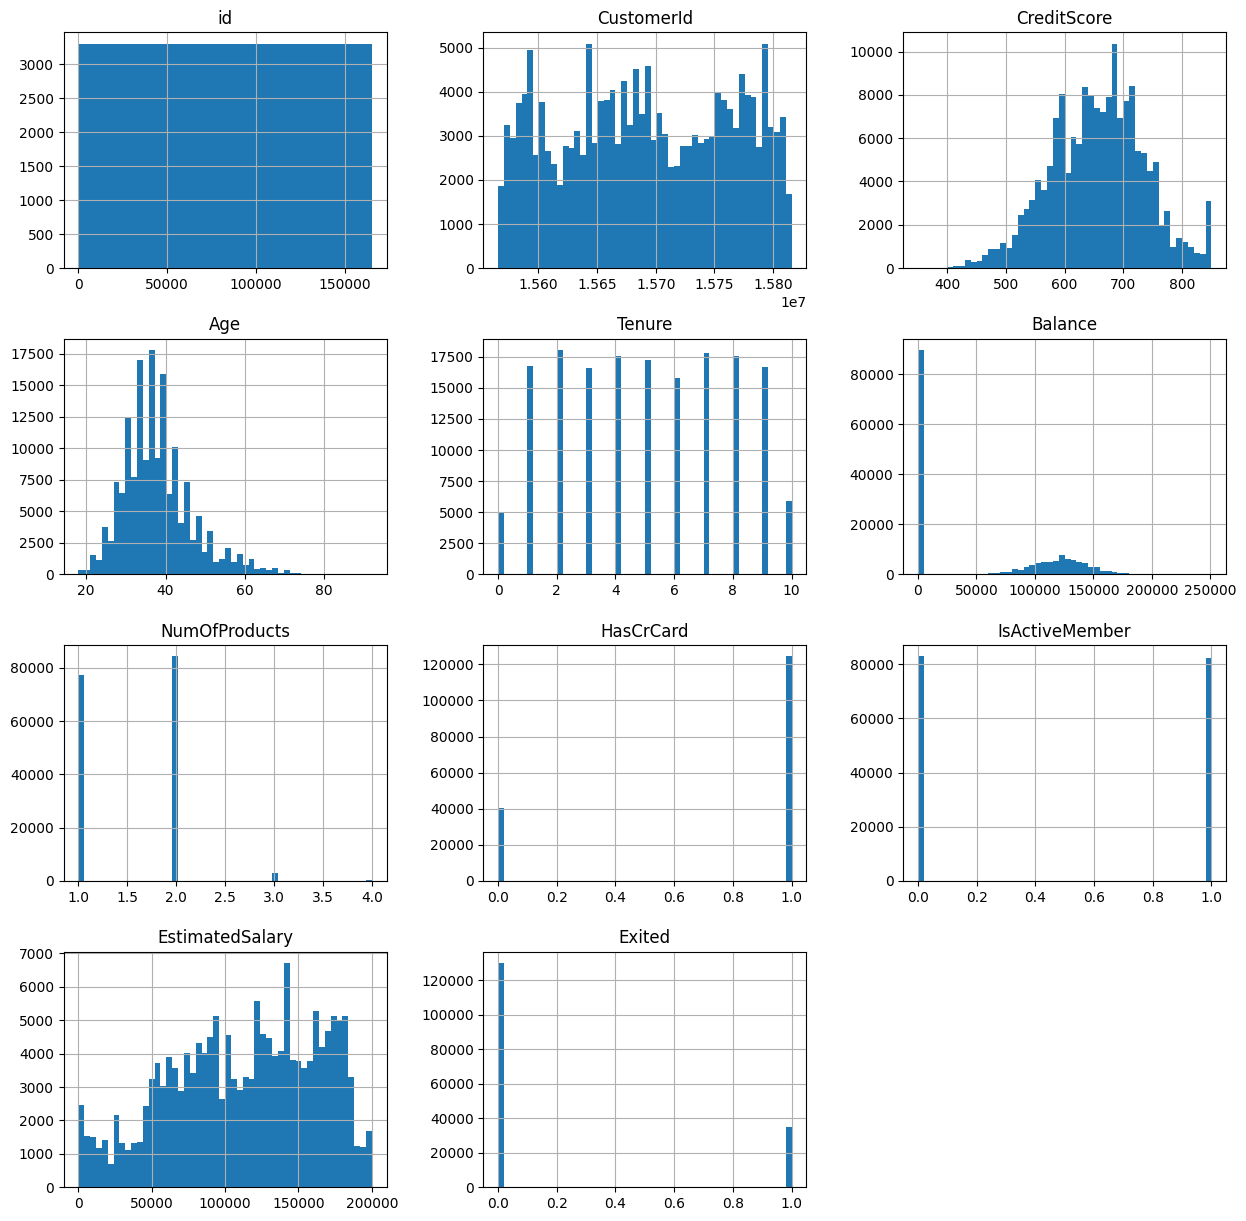

In [7]:
df_train.hist(bins=50, figsize=(15, 15))

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>, <Axes: >, <Axes: >]],
      dtype=object)

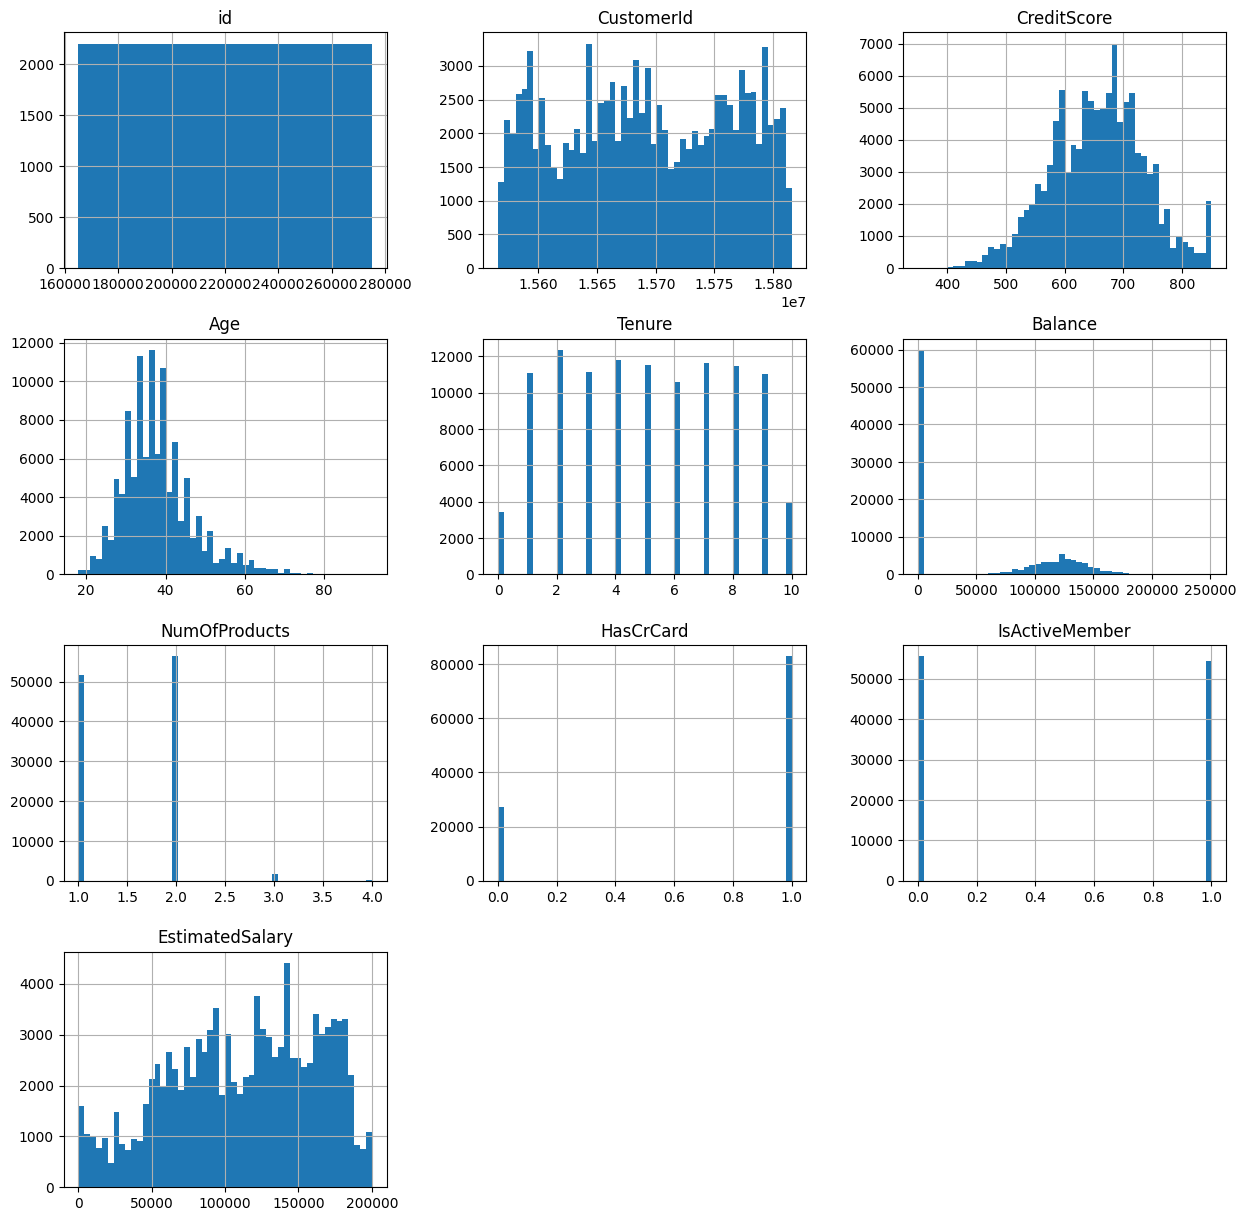

In [8]:
df_test.hist(bins=50, figsize=(15, 15))

In [9]:
df_train[['HasCrCard', 'IsActiveMember']] = df_train[['HasCrCard', 'IsActiveMember']].astype(int)

In [10]:
df_test[['HasCrCard', 'IsActiveMember']] = df_test[['HasCrCard', 'IsActiveMember']].astype(int)

# Baseline

In [11]:
df_train.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1,0,181449.97,0


In [17]:
cat_col = ['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography']
text_col = ['Surname']
info_col = ['Exited', 'id', 'CustomerId', 'Surname']
features = [f for f in df_train.columns if f not in info_col]

In [18]:
dev, test_oos = train_test_split(df_train, test_size=0.15, stratify=df_train['Exited'], random_state=42)

In [19]:
train, valid = train_test_split(dev, test_size=0.15, stratify=dev['Exited'], random_state=42)

In [20]:
train_pool, valid_pool, oos_pool, test_pool = (
    Pool(
        train[features],
        label=train['Exited'],
        cat_features=cat_col,
        text_features=None,
    ),
    Pool(
        valid[features],
        label=valid['Exited'],
        cat_features=cat_col,
        text_features=None,
    ),
    Pool(
        test_oos[features],
        label=test_oos['Exited'],
        cat_features=cat_col,
        text_features=None,
    ),
     Pool(
        df_test[features],
        cat_features=cat_col,
        text_features=None,
    )
)

In [21]:
cbc = CatBoostClassifier(
    iterations=1000,
    early_stopping_rounds=100,
    depth=4,
    eval_metric='AUC',
)

In [22]:
cbc.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.103224
0:	test: 0.8548432	best: 0.8548432 (0)	total: 232ms	remaining: 3m 51s
1:	test: 0.8548432	best: 0.8548432 (0)	total: 300ms	remaining: 2m 29s
2:	test: 0.8575838	best: 0.8575838 (2)	total: 366ms	remaining: 2m 1s
3:	test: 0.8686131	best: 0.8686131 (3)	total: 426ms	remaining: 1m 46s
4:	test: 0.8718030	best: 0.8718030 (4)	total: 491ms	remaining: 1m 37s
5:	test: 0.8774166	best: 0.8774166 (5)	total: 556ms	remaining: 1m 32s
6:	test: 0.8785219	best: 0.8785219 (6)	total: 617ms	remaining: 1m 27s
7:	test: 0.8808180	best: 0.8808180 (7)	total: 672ms	remaining: 1m 23s
8:	test: 0.8809207	best: 0.8809207 (8)	total: 736ms	remaining: 1m 21s
9:	test: 0.8813660	best: 0.8813660 (9)	total: 795ms	remaining: 1m 18s
10:	test: 0.8825586	best: 0.8825586 (10)	total: 854ms	remaining: 1m 16s
11:	test: 0.8833203	best: 0.8833203 (11)	total: 921ms	remaining: 1m 15s
12:	test: 0.8843735	best: 0.8843735 (12)	total: 987ms	remaining: 1m 14s
13:	test: 0.8858556	best: 0.8858556 (13)	total: 1.04s	r

In [23]:
def get_metric(model, pool, metric):
    return metric(pool.get_label(), model.predict(pool, prediction_type="RawFormulaVal"))


def print_cb_metrics(model, train_pool, valid_pool=None, oos_pool=None, oot_pool=None, metric=None):
    
    metrics = {
        'train': None,
        'valid': None,
        'oos': None,
        'oot': None,
    }
    
    if metric is None:
        metric = {'name': 'AUC', 'func': roc_auc_score}
    
    tr_m = get_metric(model, train_pool, metric.get('func'))
    print(f"TRAIN {metric.get('name')}: [{tr_m}]")
    metrics['train'] = tr_m
    
    if valid_pool is not None:
        v_m = get_metric(model, valid_pool, metric.get('func'))
        print(f"VALID {metric.get('name')}: [{v_m}]")
        metrics['valid'] = v_m
    
    if oos_pool is not None:
        o_m = get_metric(model, oos_pool, metric.get('func'))
        print(f"OOS {metric.get('name')}: [{o_m}]")
        metrics['oos'] = o_m
        
    if oot_pool is not None:
        ot_m = get_metric(model, oot_pool, metric.get('func'))
        print(f"OOT {metric.get('name')}: [{ot_m}]")
        metrics['oot'] = ot_m
    
    return metrics

In [24]:
auc = {'name': 'AUC', 'func': roc_auc_score}

In [25]:
print_cb_metrics(model=cbc, train_pool=train_pool, valid_pool=valid_pool, oos_pool=oos_pool, oot_pool=None, metric=auc)

TRAIN AUC: [0.8918246433178565]
VALID AUC: [0.8935897040369811]
OOS AUC: [0.8889782367113099]


{'train': 0.8918246433178565,
 'valid': 0.8935897040369811,
 'oos': 0.8889782367113099,
 'oot': None}

In [33]:
cbc.get_feature_importance()

array([ 1.46410026,  5.72758599,  3.84087854, 26.79427546,  0.36587695,
        8.69489868, 40.75958404,  0.42292082, 10.85470172,  1.07517753])

In [36]:
cbc.feature_names_

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [26]:
def get_score(score):
    mass = []
    for i in score:
        mass.append(i[1])
    return mass

In [27]:
def get_sample_submission(model, pool, df):
    pred = model.predict_proba(pool)
    pred1 = get_norm_score(pred)
    df['Exited'] = pred1
    df_fin = df[['id', 'Exited']]
    return df_fin

In [28]:
df = get_sample_submission(cbc, test_pool, df_test)

In [148]:
df.to_csv('/conda_proj/kaggle_cup/data/my_score.csv', index=False)